In [1]:
import time
import glob
import torch
import os

from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.3.0 CPU


Namespace(cfg='cfg/yolov3-spp.cfg', conf_thres=0.3, data='data/coco.data', device='', fourcc='mp4v', half=False, img_size=416, nms_thres=0.5, output='output', source='data/samples', view_img=False, weights='weights/yolov3-spp.weights')
Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', total_memory=11016MB)

image 1/2 data/samples/bus.jpg: 416x320 4 persons, 1 buss, 1 handbags, Done. (0.026s)
image 2/2 data/samples/zidane.jpg: 256x416 2 persons, 1 ties, Done. (0.023s)
Results saved to /home/jack/yolov3/output
Done. (0.133s)


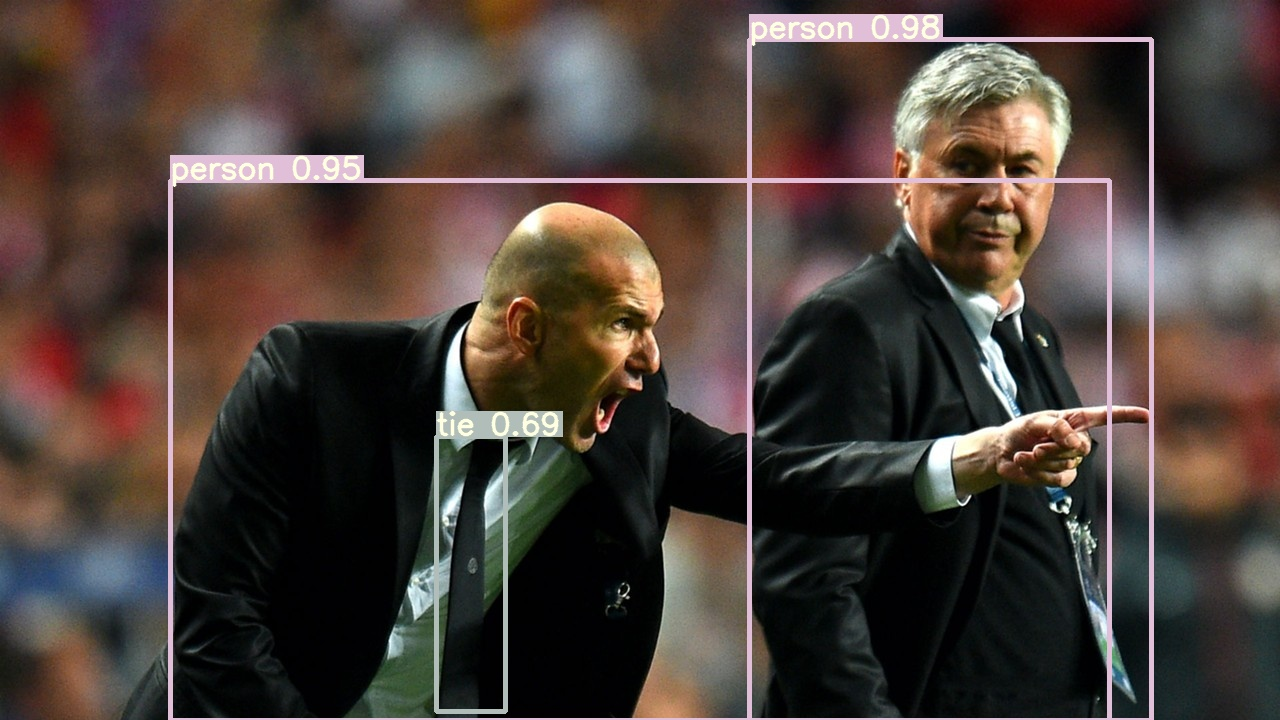

In [2]:
!python3 detect.py
Image(filename='output/zidane.jpg', width=600)